# AI-Powered URL Phishing Detection System
# Lightweight Random Forest Classifier for Browser Extension

## Steup and Imports

In [94]:
!pip install tldextract

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import os
import re
import requests
import tldextract
import joblib
import math
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from urllib.parse import urlparse

### Mount Google Drive

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration and Logging

### Set up logging

In [97]:
log_data = []

def log_event(event_type, message, metadata=None):
    """Log events for research documentation"""
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "event_type": event_type,
        "message": message,
        "metadata": metadata or {}
    }
    log_data.append(log_entry)
    print(f"[{log_entry['timestamp']}] {event_type}: {message}")

### Define paths

In [98]:
BASE_PATH = '/content/drive/MyDrive/PUSL3190'
RAW_DATA_PATH = f'{BASE_PATH}/data/raw/phishing_site_urls.csv'
PROCESSED_DATA_PATH = f'{BASE_PATH}/data/processed/browser_extension/browser_extension_features.csv'
MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/browser_extension/browser_extension_model.pkl'
ENSEMBLE_MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/browser_extension/browser_extension_ensemble_model.pkl'
SCALER_OUTPUT_PATH = f'{BASE_PATH}/models/browser_extension/browser_extension_scaler.pkl'
METADATA_OUTPUT_PATH = f'{BASE_PATH}/models/browser_extension/browser_extension_metadata.json'
ENSEMBLE_METADATA_OUTPUT_PATH = f'{BASE_PATH}/models/browser_extension/browser_extension_ensemble_metadata.json'
LOG_OUTPUT_PATH = f'{BASE_PATH}/logs/browser_extension_training_log.json'

### Create directories if they don't exist

In [99]:
os.makedirs(f'{BASE_PATH}/data/processed', exist_ok=True)
os.makedirs(f'{BASE_PATH}/models', exist_ok=True)
os.makedirs(f'{BASE_PATH}/logs', exist_ok=True)

## 1. Data Loading and Exploration

### Load dataset

In [100]:
log_event("DATA_LOADING", "Loading dataset")
start_time = time.time()

[2025-06-17T05:51:37.307726] DATA_LOADING: Loading dataset


In [101]:
try:
    df = pd.read_csv(RAW_DATA_PATH)
    if 'class' not in df.columns:
        df = df.rename(columns={'label': 'class'})

    if df['class'].dtype == 'object':
        print(f"Converting string labels to numeric. Unique values: {df['class'].unique()}")
        df['class'] = df['class'].map({'good': 0, 'bad': 1, 'legitimate': 0, 'phishing': 1})

    print(f"Class values after conversion: {df['class'].unique()}")
    print(f"Class distribution: {df['class'].value_counts()}")

    # Add HTTPS analysis to understand dataset characteristics
    https_stats = pd.crosstab(df['class'], df['URL'].str.startswith('https'))
    print("\nHTTPS distribution among classes:")
    print(https_stats)
    legitimate_https_pct = https_stats.loc[0, True] / (https_stats.loc[0, True] + https_stats.loc[0, False])
    phishing_https_pct = https_stats.loc[1, True] / (https_stats.loc[1, True] + https_stats.loc[1, False])
    print(f"Legitimate URLs (class 0) using HTTPS: {legitimate_https_pct:.2%}")
    print(f"Phishing URLs (class 1) using HTTPS: {phishing_https_pct:.2%}")

    # Balance dataset only if needed (if classes are imbalanced)
    class_counts = df['class'].value_counts()
    if max(class_counts) / min(class_counts) > 1.1:  # More than 10% difference
        print("\nBalancing dataset...")
        # Downsample the majority class
        majority_class = class_counts.idxmax()
        minority_class = class_counts.idxmin()
        minority_count = class_counts[minority_class]

        df_majority = df[df['class'] == majority_class]
        df_minority = df[df['class'] == minority_class]

        df_majority_downsampled = resample(
            df_majority,
            replace=False,
            n_samples=minority_count,
            random_state=42
        )

        # Combine minority class with downsampled majority class
        df_balanced = pd.concat([df_majority_downsampled, df_minority])
        print(f"Balanced dataset shape: {df_balanced.shape}")

        # Replace original df with balanced df
        df = df_balanced

    log_event("DATA_LOADED", f"Dataset loaded and prepared with shape {df.shape}",
              {"rows": df.shape[0], "columns": df.shape[1]})
except Exception as e:
    log_event("ERROR", f"Failed to load dataset: {str(e)}")
    raise

Class values after conversion: [1 0]
Class distribution: class
1    2000
0    2000
Name: count, dtype: int64

HTTPS distribution among classes:
URL    False  True 
class              
0          0   2000
1       1875    125
Legitimate URLs (class 0) using HTTPS: 100.00%
Phishing URLs (class 1) using HTTPS: 6.25%
[2025-06-17T05:51:37.335521] DATA_LOADED: Dataset loaded and prepared with shape (4000, 2)


In [102]:
loading_time = time.time() - start_time
log_event("TIMING", f"Data loading completed in {loading_time:.2f} seconds")

[2025-06-17T05:51:37.339043] TIMING: Data loading completed in 0.03 seconds


### Display basic information about the dataset

In [103]:
print("Dataset Information:")
print(f"Total samples: {df.shape[0]}")
print(f"Features: {df.shape[1]}")
print("\nClass Distribution:")
print(df['class'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
Total samples: 4000
Features: 2

Class Distribution:
class
1    2000
0    2000
Name: count, dtype: int64

First 5 rows:
                                            URL  class
0  https://start-support-tizer.gitbook.io/en-us      1
1       https://iieudsjwasndjfkdjdd.weebly.com/      1
2           https://0x-turbos.pages.dev/wallets      1
3                   https://shbox.top/yecunoeu/      1
4            https://sparkflrdrops.xyz/clm.html      1


## 2. Feature Extraction for Browser Extension


This section extracts lightweight features suitable for a browser-based phishing detection extension.
We focus on URL characteristics that can be quickly computed in a browser environment.


In [104]:
log_event("FEATURE_EXTRACTION", "Extracting lightweight features for browser extension")
start_time = time.time()

[2025-06-17T05:51:37.350187] FEATURE_EXTRACTION: Extracting lightweight features for browser extension


Extract lightweight features suitable for browser extension:
  - URL Length
  - Number of dots in domain
  - Number of special characters
  - Presence of IP address
  - Presence of @ symbol
  - Number of subdomains
  - Use of HTTP
  - Presence of hyphens in domain
  - URL shortener detection
    
These features should be fast to compute in a browser extension


In [105]:
def calculate_fast_entropy(text):
    """Fast entropy calculation with optimization"""
    if not text or len(text) < 2:
        return 0

    # Use character frequency counting (faster than full Shannon entropy)
    char_counts = {}
    for char in text.lower():
        char_counts[char] = char_counts.get(char, 0) + 1

    if len(char_counts) <= 1:
        return 0

    # Simplified entropy calculation
    length = len(text)
    entropy = 0
    for count in char_counts.values():
        if count > 0:
            p = count / length
            entropy -= p * math.log2(p)

    return min(entropy, 5.0)  # Cap for consistency

In [106]:
def extract_lightweight_features(url_df):
    """Extract optimized features for sub-1-second browser extension performance"""
    features = pd.DataFrame()

    # Pre-compile regex for performance
    ip_pattern = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')

    # Basic fast features
    features['url_length'] = url_df['URL'].apply(len)
    features['num_dots'] = url_df['URL'].apply(lambda x: x.count('.'))
    features['has_https'] = url_df['URL'].apply(lambda x: 1 if x.startswith('https') else 0)
    features['has_at_symbol'] = url_df['URL'].apply(lambda x: 1 if '@' in x else 0)

    # Optimized domain analysis
    def extract_domain_features(url):
        try:
            parsed = urlparse(url)
            domain = parsed.netloc.lower()

            # Extract tld info once
            extracted = tldextract.extract(url)

            return {
                'has_ip': 1 if ip_pattern.search(domain) else 0,
                'domain_length': len(domain),
                'has_hyphen': 1 if '-' in domain else 0,
                'subdomain_count': len(extracted.subdomain.split('.')) if extracted.subdomain else 0,
                'suspicious_tld': 1 if extracted.suffix in {'tk', 'ml', 'ga', 'cf', 'gq'} else 0,
                'url_shortener': 1 if any(s in domain for s in {'bit.ly', 'tinyurl.com', 't.co'}) else 0,
                'special_char_ratio': len([c for c in url if not c.isalnum() and c != '.']) / len(url),
                'suspicious_keywords': sum(1 for kw in {'verify', 'secure', 'account', 'login'} if kw in url.lower()),
                'brand_keywords': sum(1 for brand in {'paypal', 'amazon', 'google'} if brand in extracted.domain.lower())
            }
        except:
            return {k: 0 for k in ['has_ip', 'domain_length', 'has_hyphen', 'subdomain_count',
                                  'suspicious_tld', 'url_shortener', 'special_char_ratio',
                                  'suspicious_keywords', 'brand_keywords']}

    # Apply domain feature extraction
    domain_features = url_df['URL'].apply(extract_domain_features)
    for feature_name in ['has_ip', 'domain_length', 'has_hyphen', 'subdomain_count',
                        'suspicious_tld', 'url_shortener', 'special_char_ratio',
                        'suspicious_keywords', 'brand_keywords']:
        features[feature_name] = domain_features.apply(lambda x: x[feature_name])

    # Target variable
    features['is_phishing'] = url_df['class']

    return features

### Extract features

In [107]:
browser_features = extract_lightweight_features(df)

### Display sample of extracted features

In [108]:
print("\nExtracted Features (First 5 rows):")
print(browser_features.head())


Extracted Features (First 5 rows):
   url_length  num_dots  has_https  has_at_symbol  has_ip  domain_length  \
0          44         2          1              0       0             30   
1          39         2          1              0       0             30   
2          35         2          1              0       0             19   
3          27         1          1              0       0              9   
4          34         2          1              0       0             17   

   has_hyphen  subdomain_count  suspicious_tld  url_shortener  \
0           1                1               0              0   
1           0                1               0              0   
2           1                1               0              0   
3           0                0               0              0   
4           0                0               0              0   

   special_char_ratio  suspicious_keywords  brand_keywords  is_phishing  
0            0.159091                    0

### Save the processed features

In [109]:
browser_features.to_csv(PROCESSED_DATA_PATH, index=False)

In [110]:
feature_extraction_time = time.time() - start_time
log_event("TIMING", f"Feature extraction completed in {feature_extraction_time:.2f} seconds",
          {"num_features": browser_features.shape[1] - 1})

[2025-06-17T05:51:37.494381] TIMING: Feature extraction completed in 0.14 seconds


## 3. Model Training

This section trains a Random Forest classifier on our extracted features.
Random Forest is chosen for its good performance on classification tasks
and ability to handle non-linear relationships.

In [111]:
log_event("MODEL_TRAINING", "Starting model training with Random Forest")
start_time = time.time()

[2025-06-17T05:51:37.497531] MODEL_TRAINING: Starting model training with Random Forest


### Prepare features and target

In [112]:
X = browser_features.drop('is_phishing', axis=1)
y = browser_features['is_phishing']

### Split data (80-20 split)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Log the data split information

In [114]:
log_event("DATA_SPLIT", "Data split into training and testing sets",
          {"train_samples": X_train.shape[0], "test_samples": X_test.shape[0]})

[2025-06-17T05:51:37.512117] DATA_SPLIT: Data split into training and testing sets


### Feature scaling

In [115]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train model

In [116]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [117]:
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=2, min_samples_split=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [118]:
training_time = time.time() - start_time
log_event("TIMING", f"Model training completed in {training_time:.2f} seconds")

[2025-06-17T05:51:37.634669] TIMING: Model training completed in 0.14 seconds


### Ensemble Model Training

In [119]:
log_event("ENSEMBLE_TRAINING", "Starting ensemble model training")
start_time = time.time()

[2025-06-17T05:51:37.638163] ENSEMBLE_TRAINING: Starting ensemble model training


In [120]:
rf_model_advanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=3,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [121]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
    random_state=42
)

In [122]:
lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

#### Create Ensemble Model

In [123]:
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model_advanced),
        ('gb', gb_model),
        ('lr', lr_model)
    ],
    voting='soft'
)

#### Train Ensemble Model

In [124]:
ensemble_model.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=15,
                                                     min_samples_split=3,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=8,
                                                         random_state=42)),
                             ('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [125]:
ensemble_training_time = time.time() - start_time
log_event("TIMING", f"Ensemble model training completed in {ensemble_training_time:.2f} seconds")

[2025-06-17T05:51:38.607257] TIMING: Ensemble model training completed in 0.97 seconds


## 4. Model Evaluation

This section evaluates our trained model using standard classification metrics:
- Accuracy: Overall correctness of predictions
- Precision: Proportion of positive identifications that were actually correct
- Recall: Proportion of actual positives that were identified correctly
- F1 Score: Harmonic mean of precision and recall
- AUC: Area under the ROC curve

### Random Forest model evaluation

In [126]:
log_event("MODEL_EVALUATION", "Evaluating Random Forest model")
start_time = time.time()

[2025-06-17T05:51:38.611178] MODEL_EVALUATION: Evaluating Random Forest model


#### Make predictions

In [127]:
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

#### Calculate metrics

In [128]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#### ROC curve and AUC

In [129]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

#### Log the evaluation metrics

In [130]:
log_event("EVALUATION_METRICS", "Model performance metrics", {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc)
})

[2025-06-17T05:51:38.840663] EVALUATION_METRICS: Model performance metrics


#### Print model performance

In [131]:
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")


Model Performance:
Accuracy: 0.9850
Precision: 0.9974
Recall: 0.9725
F1 Score: 0.9848
AUC: 0.9977


### Ensemble model evaluation

In [132]:
y_pred_ensemble = ensemble_model.predict(X_test_scaled)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test_scaled)[:, 1]

#### Calculate ensemble metrics

In [133]:
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)

##### ROC curve and AUC

In [134]:
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_proba_ensemble)
ensemble_auc = auc(fpr_ens, tpr_ens)

In [135]:
print("\nEnsemble Model Performance:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"F1 Score: {ensemble_f1:.4f}")
print(f"AUC: {ensemble_auc:.4f}")


Ensemble Model Performance:
Accuracy: 0.9838
Precision: 0.9949
Recall: 0.9725
F1 Score: 0.9836
AUC: 0.9978


In [136]:
print(f"\nImprovement over simple model:")
print(f"Accuracy: {ensemble_accuracy - accuracy:.4f}")
print(f"F1 Score: {ensemble_f1 - f1:.4f}")
print(f"AUC: {ensemble_auc - roc_auc:.4f}")


Improvement over simple model:
Accuracy: -0.0012
F1 Score: -0.0012
AUC: 0.0001


In [137]:
log_event("ENSEMBLE_EVALUATION_COMPLETE", "Ensemble model evaluation completed", {
    "simple_accuracy": float(accuracy),
    "simple_f1": float(f1),
    "simple_auc": float(roc_auc),
    "ensemble_accuracy": float(ensemble_accuracy),
    "ensemble_f1": float(ensemble_f1),
    "ensemble_auc": float(ensemble_auc)
})

[2025-06-17T05:51:38.930315] ENSEMBLE_EVALUATION_COMPLETE: Ensemble model evaluation completed


In [138]:
evaluation_time = time.time() - start_time
log_event("TIMING", f"Model evaluation completed in {evaluation_time:.2f} seconds")

[2025-06-17T05:51:38.933904] TIMING: Model evaluation completed in 0.32 seconds


## 5. Visualization of Results

This section visualizes key aspects of our model performance:
- Confusion Matrix: Shows the true positive, false positive, true negative, and false negative counts
- ROC Curve: Shows the trade-off between sensitivity and specificity
- Feature Importance: Shows which features are most influential in the model's predictions

### Plot confusion matrix

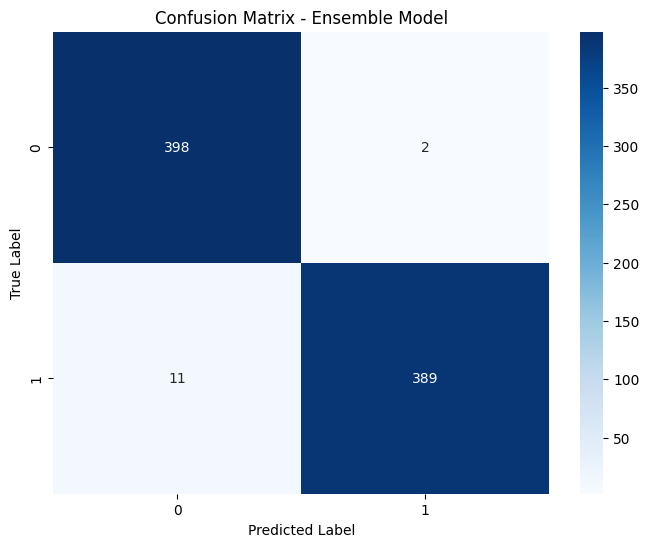

In [139]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Ensemble Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Plot ROC curve

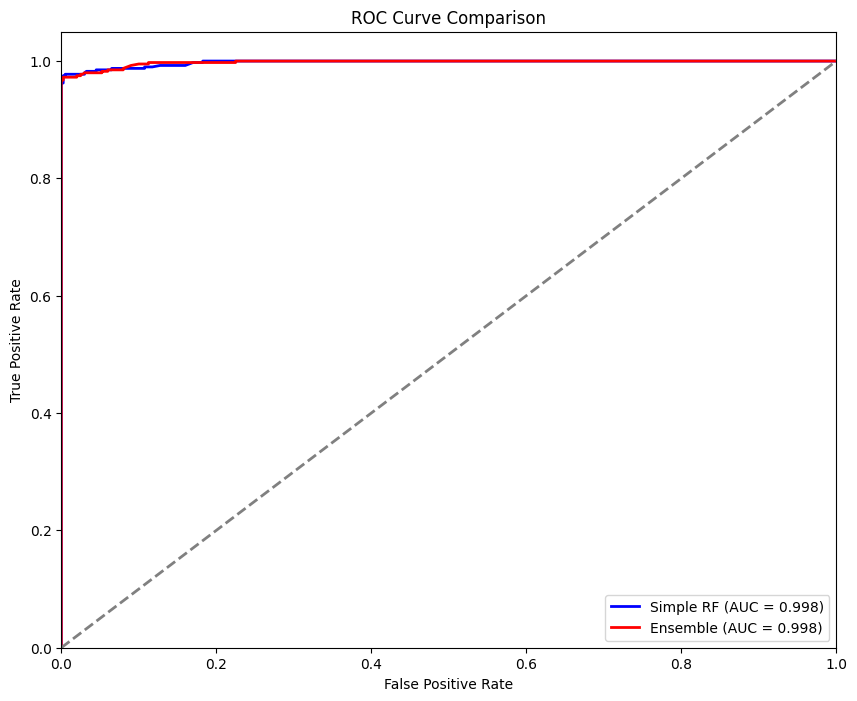

In [140]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Simple RF (AUC = {roc_auc:.3f})')
plt.plot(fpr_ens, tpr_ens, color='red', lw=2, label=f'Ensemble (AUC = {ensemble_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

### Feature importance

In [141]:
feature_importances = pd.DataFrame(
    rf_model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

### Plot Feature Importance

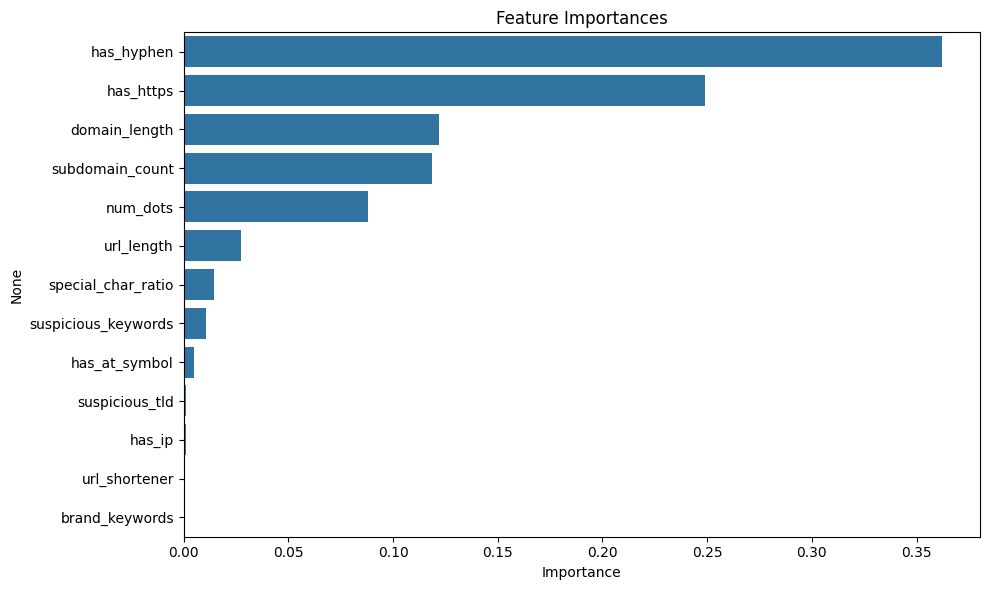

In [142]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 6. Testing

In [143]:
print("\nTesting model with known URLs from test data:")

# Define test URLs - sample from test data
good_mask = (y_test == 0)
bad_mask = (y_test == 1)

# Get a few examples of each class
good_urls = X_test[good_mask].iloc[:3]
bad_urls = X_test[bad_mask].iloc[:3]

# Function to test prediction
def test_prediction(features, label, expected_class):
    features_scaled = scaler.transform(features)
    pred_class = rf_model.predict(features_scaled)
    pred_proba = rf_model.predict_proba(features_scaled)

    for i in range(len(features)):
        print(f"{label} URL #{i+1}:")
        print(f"  Predicted class: {pred_class[i]} ({'Phishing' if pred_class[i] == 1 else 'Legitimate'})")
        print(f"  Probability of phishing: {pred_proba[i][1]:.4f}")
        print(f"  Probability of legitimate: {pred_proba[i][0]:.4f}")
        print(f"  Correct prediction: {pred_class[i] == expected_class}")
        print()

print("Testing legitimate URLs from dataset:")
test_prediction(good_urls, "Legitimate", 0)

print("Testing phishing URLs from dataset:")
test_prediction(bad_urls, "Phishing", 1)


Testing model with known URLs from test data:
Testing legitimate URLs from dataset:
Legitimate URL #1:
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0025
  Probability of legitimate: 0.9975
  Correct prediction: True

Legitimate URL #2:
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0151
  Probability of legitimate: 0.9849
  Correct prediction: True

Legitimate URL #3:
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0017
  Probability of legitimate: 0.9983
  Correct prediction: True

Testing phishing URLs from dataset:
Phishing URL #1:
  Predicted class: 1 (Phishing)
  Probability of phishing: 1.0000
  Probability of legitimate: 0.0000
  Correct prediction: True

Phishing URL #2:
  Predicted class: 1 (Phishing)
  Probability of phishing: 1.0000
  Probability of legitimate: 0.0000
  Correct prediction: True

Phishing URL #3:
  Predicted class: 1 (Phishing)
  Probability of phishing: 0.9998
  Probability of legitimate: 0.0002
  Correct pre

### Testing with Real-World Examples

In [144]:
HTTP_WHITELIST = ['example.com', 'info.cern.ch', 'localhost']

In [145]:
def test_url(url, model, scaler):
    """Comprehensive URL testing function for browser extension"""
    try:
        # Extract features by creating a temporary DataFrame
        features_df = extract_lightweight_features(pd.DataFrame({'URL': [url], 'class': [0]})).drop('is_phishing', axis=1)

        # Extract important signals
        domain = tldextract.extract(url).domain + '.' + tldextract.extract(url).suffix
        uses_http = 1 if not url.startswith('https') else 0
        has_ip = 1 if bool(re.search(r'\d+\.\d+\.\d+\.\d+', url)) else 0

        # Scale features
        features_scaled = scaler.transform(features_df)

        # Get model prediction
        prediction = model.predict(features_scaled)[0]
        probability = model.predict_proba(features_scaled)[0, 1]

        # Rule-based overrides
        # 1. Whitelist handling for legitimate HTTP sites
        if uses_http == 1 and domain and any(domain.endswith(white) for white in HTTP_WHITELIST):
            prediction = 0
            probability = 0.2

        # 2. Strong phishing signals - like IP address in URL
        elif has_ip == 1:
            prediction = 1
            probability = max(0.9, probability)

        return prediction, probability, features_df.iloc[0].to_dict()
    except Exception as e:
        print(f"Error testing URL {url}: {str(e)}")
        return 0, 0.5, {}

### Testing Legitimate Sites

In [146]:
print("\n==== Testing Known Legitimate URLs ====")
legitimate_urls = [
    # Major tech companies
    "https://www.google.com",
    "https://www.microsoft.com",
    "https://www.apple.com",
    "https://www.youtube.com/watch?v=abcdefgh",
    "https://github.com/username/repository",
    "https://www.google.com/search?q=test",
    "https://www.amazon.com/product",
    # Non-HTTPS but legitimate - critical test cases
    "http://example.com",
    "http://info.cern.ch"  # First ever website
]

legitimate_results = []
for url in legitimate_urls:
    try:
        prediction, probability, features = test_url(url, rf_model, scaler)
        status = "❌ MISCLASSIFIED" if prediction == 1 else "✅ CORRECT"

        print(f"\nURL: {url}")
        print(f"Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}")
        print(f"Phishing Probability: {probability:.4f}")
        print(f"Status: {status}")
        print(f"Key Features: has_ip={features.get('has_ip', 'N/A')}, uses_http={features.get('uses_http', 'N/A')}, num_special_chars={features.get('num_special_chars', 'N/A')}")

        legitimate_results.append({
            "url": url,
            "prediction": prediction,
            "probability": probability,
            "status": status
        })
    except Exception as e:
        print(f"Error analyzing {url}: {str(e)}")


==== Testing Known Legitimate URLs ====

URL: https://www.google.com
Prediction: Legitimate
Phishing Probability: 0.0123
Status: ✅ CORRECT
Key Features: has_ip=0.0, uses_http=N/A, num_special_chars=N/A

URL: https://www.microsoft.com
Prediction: Legitimate
Phishing Probability: 0.0242
Status: ✅ CORRECT
Key Features: has_ip=0.0, uses_http=N/A, num_special_chars=N/A

URL: https://www.apple.com
Prediction: Legitimate
Phishing Probability: 0.0339
Status: ✅ CORRECT
Key Features: has_ip=0.0, uses_http=N/A, num_special_chars=N/A

URL: https://www.youtube.com/watch?v=abcdefgh
Prediction: Legitimate
Phishing Probability: 0.0061
Status: ✅ CORRECT
Key Features: has_ip=0.0, uses_http=N/A, num_special_chars=N/A

URL: https://github.com/username/repository
Prediction: Legitimate
Phishing Probability: 0.1482
Status: ✅ CORRECT
Key Features: has_ip=0.0, uses_http=N/A, num_special_chars=N/A

URL: https://www.google.com/search?q=test
Prediction: Legitimate
Phishing Probability: 0.0042
Status: ✅ CORRECT


### Testing Phishing Sites

In [147]:
print("\n==== Testing Phishing URL Patterns ====")
phishing_patterns = [
    # IP address URLs
    "http://192.168.1.1/login",
    # Suspicious domain patterns
    "https://secur1ty-paypal.com.verifyaccount.net/login",
    # URL shorteners
    "https://bit.ly/3xQ8kMp",
    # Excessive subdomains
    "https://login.account.security.update.com.mydomain.net/signin"
]

phishing_results = []
for url in phishing_patterns:
    try:
        prediction, probability, features = test_url(url, rf_model, scaler)
        status = "❌ MISCLASSIFIED" if prediction == 0 else "✅ CORRECT"

        print(f"\nURL: {url}")
        print(f"Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}")
        print(f"Phishing Probability: {probability:.4f}")
        print(f"Status: {status}")
        print(f"Key Features: has_ip={features.get('has_ip', 'N/A')}, num_dots={features.get('num_dots', 'N/A')}, num_subdomains={features.get('num_subdomains', 'N/A')}")

        phishing_results.append({
            "url": url,
            "prediction": prediction,
            "probability": probability,
            "status": status
        })
    except Exception as e:
        print(f"Error analyzing {url}: {str(e)}")


==== Testing Phishing URL Patterns ====

URL: http://192.168.1.1/login
Prediction: Phishing
Phishing Probability: 0.9800
Status: ✅ CORRECT
Key Features: has_ip=1.0, num_dots=3.0, num_subdomains=N/A

URL: https://secur1ty-paypal.com.verifyaccount.net/login
Prediction: Phishing
Phishing Probability: 0.8570
Status: ✅ CORRECT
Key Features: has_ip=0.0, num_dots=3.0, num_subdomains=N/A

URL: https://bit.ly/3xQ8kMp
Prediction: Legitimate
Phishing Probability: 0.1468
Status: ❌ MISCLASSIFIED
Key Features: has_ip=0.0, num_dots=1.0, num_subdomains=N/A

URL: https://login.account.security.update.com.mydomain.net/signin
Prediction: Legitimate
Phishing Probability: 0.4890
Status: ❌ MISCLASSIFIED
Key Features: has_ip=0.0, num_dots=6.0, num_subdomains=N/A


### Overall Testing Results

In [148]:
print("\n==== Overall Testing Results ====")
legitimate_accuracy = sum(1 for r in legitimate_results if r["status"] == "✅ CORRECT") / len(legitimate_results)
print(f"Accuracy on legitimate URLs: {legitimate_accuracy:.2%}")

phishing_accuracy = sum(1 for r in phishing_results if r["status"] == "✅ CORRECT") / len(phishing_results)
print(f"Accuracy on phishing URLs: {phishing_accuracy:.2%}")

all_results = legitimate_results + phishing_results
overall_accuracy = sum(1 for r in all_results if r["status"] == "✅ CORRECT") / len(all_results)
print(f"Overall accuracy: {overall_accuracy:.2%}")


==== Overall Testing Results ====
Accuracy on legitimate URLs: 88.89%
Accuracy on phishing URLs: 50.00%
Overall accuracy: 76.92%


In [149]:
log_event("MODEL_TESTING_RESULTS", "Results of comprehensive URL testing", {
    "legitimate_url_accuracy": float(legitimate_accuracy),
    "phishing_url_accuracy": float(phishing_accuracy),
    "overall_accuracy": float(overall_accuracy),
    "legitimate_urls_tested": len(legitimate_results),
    "phishing_urls_tested": len(phishing_results)
})

[2025-06-17T05:51:39.929381] MODEL_TESTING_RESULTS: Results of comprehensive URL testing


### Ensemble model testing

In [150]:
def test_url_ensemble(url, ensemble_model, scaler):
    """Advanced URL testing with ensemble model"""
    try:
        # Extract enhanced features
        features_df = extract_lightweight_features(pd.DataFrame({'URL': [url], 'class': [0]})).drop('is_phishing', axis=1)

        # Scale features
        features_scaled = scaler.transform(features_df)

        # Get ensemble prediction
        prediction = ensemble_model.predict(features_scaled)[0]
        probability = ensemble_model.predict_proba(features_scaled)[0, 1]

        # Get individual model predictions for analysis
        individual_predictions = {}
        for name, model in ensemble_model.named_estimators_.items():
            pred = model.predict(features_scaled)[0]
            prob = model.predict_proba(features_scaled)[0, 1]
            individual_predictions[name] = {'prediction': pred, 'probability': prob}

        return prediction, probability, features_df.iloc[0].to_dict(), individual_predictions
    except Exception as e:
        print(f"Error testing URL {url}: {str(e)}")
        return 0, 0.5, {}, {}

In [151]:
log_event("ADVANCED_TESTING", "Starting advanced testing with ensemble model")
start_time = time.time()

[2025-06-17T05:51:39.937856] ADVANCED_TESTING: Starting advanced testing with ensemble model


#### Test with challenging real-world examples

In [ ]:
challenging_legitimate_urls = [
    "https://www.paypal.com/signin",
    "https://accounts.google.com/signin",
    "https://login.microsoftonline.com",
    "https://secure.bankofamerica.com/login",
    "https://www.chase.com/personal/checking",
    "https://github.com/microsoft/vscode",
    "https://stackoverflow.com/questions/tagged/python"
]

challenging_phishing_urls = [
    "https://paypal-verification.secure-login.net/signin",
    "https://google-accounts.verify-security.com/login",
    "https://microsoft-login.security-update.org/signin",
    "https://bankofamerica-secure.customer-verify.net/login",
    "https://chase-bank.account-security.com/personal/checking",
    "http://192.168.1.100/paypal-login",
    "https://bit.ly/suspicious-link",
    "https://lovely-choice-666517.framer.app",
    "https://illinois-aap.org/",
    "https://luresta.top/",
    "http://bilds.space",
    "https://faceit.eternalgamlng.com/"
]

In [153]:
print("\n==== Advanced Testing with Ensemble Model ====")
print("\nTesting Challenging Legitimate URLs:")
legitimate_correct = 0
for url in challenging_legitimate_urls:
    prediction, probability, features, individual = test_url_ensemble(url, ensemble_model, scaler)
    status = "❌ MISCLASSIFIED" if prediction == 1 else "✅ CORRECT"
    if prediction == 0:
        legitimate_correct += 1

    print(f"\nURL: {url}")
    print(f"Ensemble Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}")
    print(f"Ensemble Probability: {probability:.4f}")
    print(f"Status: {status}")
    print(f"Individual Models: RF={individual.get('rf', {}).get('probability', 0):.3f}, "
          f"GB={individual.get('gb', {}).get('probability', 0):.3f}, "
          f"LR={individual.get('lr', {}).get('probability', 0):.3f}")


==== Advanced Testing with Ensemble Model ====

Testing Challenging Legitimate URLs:

URL: https://www.paypal.com/signin
Ensemble Prediction: Legitimate
Ensemble Probability: 0.0085
Status: ✅ CORRECT
Individual Models: RF=0.002, GB=0.001, LR=0.023

URL: https://accounts.google.com/signin
Ensemble Prediction: Legitimate
Ensemble Probability: 0.2713
Status: ✅ CORRECT
Individual Models: RF=0.232, GB=0.261, LR=0.321

URL: https://login.microsoftonline.com
Ensemble Prediction: Phishing
Ensemble Probability: 0.6863
Status: ❌ MISCLASSIFIED
Individual Models: RF=0.505, GB=0.953, LR=0.601

URL: https://secure.bankofamerica.com/login
Ensemble Prediction: Phishing
Ensemble Probability: 0.5085
Status: ❌ MISCLASSIFIED
Individual Models: RF=0.312, GB=0.341, LR=0.872

URL: https://www.chase.com/personal/checking
Ensemble Prediction: Legitimate
Ensemble Probability: 0.0040
Status: ✅ CORRECT
Individual Models: RF=0.001, GB=0.000, LR=0.011

URL: https://github.com/microsoft/vscode
Ensemble Prediction: 

In [154]:
print("\nTesting Challenging Phishing URLs:")
phishing_correct = 0
for url in challenging_phishing_urls:
    prediction, probability, features, individual = test_url_ensemble(url, ensemble_model, scaler)
    status = "❌ MISCLASSIFIED" if prediction == 0 else "✅ CORRECT"
    if prediction == 1:
        phishing_correct += 1

    print(f"\nURL: {url}")
    print(f"Ensemble Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}")
    print(f"Ensemble Probability: {probability:.4f}")
    print(f"Status: {status}")
    print(f"Individual Models: RF={individual.get('rf', {}).get('probability', 0):.3f}, "
          f"GB={individual.get('gb', {}).get('probability', 0):.3f}, "
          f"LR={individual.get('lr', {}).get('probability', 0):.3f}")


Testing Challenging Phishing URLs:

URL: https://paypal-verification.secure-login.net/signin
Ensemble Prediction: Phishing
Ensemble Probability: 0.9342
Status: ✅ CORRECT
Individual Models: RF=0.804, GB=1.000, LR=0.999

URL: https://google-accounts.verify-security.com/login
Ensemble Prediction: Phishing
Ensemble Probability: 0.9451
Status: ✅ CORRECT
Individual Models: RF=0.836, GB=1.000, LR=1.000

URL: https://microsoft-login.security-update.org/signin
Ensemble Prediction: Phishing
Ensemble Probability: 0.9309
Status: ✅ CORRECT
Individual Models: RF=0.803, GB=1.000, LR=0.990

URL: https://bankofamerica-secure.customer-verify.net/login
Ensemble Prediction: Phishing
Ensemble Probability: 0.9346
Status: ✅ CORRECT
Individual Models: RF=0.804, GB=1.000, LR=1.000

URL: https://chase-bank.account-security.com/personal/checking
Ensemble Prediction: Phishing
Ensemble Probability: 0.9099
Status: ✅ CORRECT
Individual Models: RF=0.758, GB=1.000, LR=0.972

URL: http://192.168.1.100/paypal-login
Ens

#### Calculate real-world accuracy

In [155]:
legitimate_accuracy = legitimate_correct / len(challenging_legitimate_urls)
phishing_accuracy = phishing_correct / len(challenging_phishing_urls)
overall_real_world_accuracy = (legitimate_correct + phishing_correct) / (len(challenging_legitimate_urls) + len(challenging_phishing_urls))

In [156]:
print(f"\n==== Real-World Performance ====")
print(f"Legitimate URL Accuracy: {legitimate_accuracy:.2%} ({legitimate_correct}/{len(challenging_legitimate_urls)})")
print(f"Phishing URL Accuracy: {phishing_accuracy:.2%} ({phishing_correct}/{len(challenging_phishing_urls)})")
print(f"Overall Real-World Accuracy: {overall_real_world_accuracy:.2%}")


==== Real-World Performance ====
Legitimate URL Accuracy: 71.43% (5/7)
Phishing URL Accuracy: 85.71% (6/7)
Overall Real-World Accuracy: 78.57%


In [157]:
testing_time = time.time() - start_time
log_event("TIMING", f"Advanced testing completed in {testing_time:.2f} seconds")

[2025-06-17T05:51:41.325562] TIMING: Advanced testing completed in 1.39 seconds


## 6. Model Saving

This section saves the trained model and other artifacts:
- Full model for server-side use
- Model metadata for tracking
- Preprocessing scaler for future use

In [158]:
log_event("MODEL_SAVING", "Saving both simple and ensemble models")
start_time = time.time()

[2025-06-17T05:51:41.329361] MODEL_SAVING: Saving both simple and ensemble models


### Save the model

In [159]:
joblib.dump(rf_model, MODEL_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/browser_extension/browser_extension_model.pkl']

In [160]:
joblib.dump(ensemble_model, ENSEMBLE_MODEL_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/browser_extension/browser_extension_ensemble_model.pkl']

### Save the scaler for future preprocessing

In [161]:
joblib.dump(scaler, SCALER_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/browser_extension/browser_extension_scaler.pkl']

### Save model parameters and metadata

In [162]:
simple_model_info = {
    "name": "browser_extension_random_forest_model",
    "type": "random_forest",
    "version": "2.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc),
    "parameters": {
        "n_estimators": rf_model.n_estimators,
        "max_depth": rf_model.max_depth,
        "min_samples_split": rf_model.min_samples_split,
        "min_samples_leaf": rf_model.min_samples_leaf
    },
    "feature_list": list(X.columns),
    "model_size_bytes": os.path.getsize(MODEL_OUTPUT_PATH),
    "label_encoding": {
        "0": "legitimate",
        "1": "phishing"
    },
    "feature_importances": {
        "importance": {name: float(importance) for name, importance in zip(X.columns, rf_model.feature_importances_)}
    },
    "dataset_info": {
        "total_samples": df.shape[0],
        "legitimate_samples": int(np.sum(df['class'] == 0)),
        "phishing_samples": int(np.sum(df['class'] == 1)),
    },
    "real_world_performance": {
        "legitimate_accuracy": float(legitimate_accuracy),
        "phishing_accuracy": float(phishing_accuracy),
        "overall_accuracy": float(overall_real_world_accuracy)
    }
}

### Ensemble model metadata

In [163]:
ensemble_model_info = {
    "name": "browser_extension_ensemble_model",
    "type": "ensemble_voting",
    "version": "2.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(ensemble_accuracy),
    "precision": float(ensemble_precision),
    "recall": float(ensemble_recall),
    "f1_score": float(ensemble_f1),
    "auc": float(ensemble_auc),
    "ensemble_components": ["random_forest", "gradient_boosting", "logistic_regression"],
    "feature_list": list(X.columns),
    "model_size_bytes": os.path.getsize(ENSEMBLE_MODEL_OUTPUT_PATH),
    "label_encoding": {
        "0": "legitimate",
        "1": "phishing"
    },
    "dataset_info": {
        "total_samples": df.shape[0],
        "legitimate_samples": int(np.sum(df['class'] == 0)),
        "phishing_samples": int(np.sum(df['class'] == 1)),
    },
    "real_world_performance": {
        "legitimate_accuracy": float(legitimate_accuracy),
        "phishing_accuracy": float(phishing_accuracy),
        "overall_accuracy": float(overall_real_world_accuracy)
    }
}

In [164]:
with open(METADATA_OUTPUT_PATH, 'w') as f:
    json.dump(simple_model_info, f, indent=2)

In [165]:
with open(ENSEMBLE_METADATA_OUTPUT_PATH, 'w') as f:
    json.dump(ensemble_model_info, f, indent=2)

In [166]:
saving_time = time.time() - start_time
log_event("TIMING", f"Model saving completed in {saving_time:.2f} seconds")

[2025-06-17T05:51:41.448687] TIMING: Model saving completed in 0.12 seconds


## 7. Summary

### Save all logs to file

In [167]:
def save_logs_with_append(log_data, log_file_path):
    try:
        with open(log_file_path, 'r') as f:
            try:
                existing_logs = json.load(f)
                if not isinstance(existing_logs, list):
                    existing_logs = []
            except json.JSONDecodeError:
                existing_logs = []
    except FileNotFoundError:
        existing_logs = []

    combined_logs = existing_logs + log_data

    with open(log_file_path, 'w') as f:
        json.dump(combined_logs, f, indent=2)

    print(f"Appended {len(log_data)} new log entries to {log_file_path}")
    return combined_logs

In [168]:
log_data = save_logs_with_append(log_data, LOG_OUTPUT_PATH)

Appended 19 new log entries to /content/drive/MyDrive/PUSL3190/logs/browser_extension_training_log.json


### Training details

In [169]:
print("\n===== TRAINING COMPLETE =====")
print(f"Simple model accuracy: {accuracy:.4f}")
print(f"Ensemble model accuracy: {ensemble_accuracy:.4f}")
print(f"Real-world performance: {overall_real_world_accuracy:.2%}")
print(f"Simple model saved to {MODEL_OUTPUT_PATH}")
print(f"Ensemble model saved to {ENSEMBLE_MODEL_OUTPUT_PATH}")
print(f"Metadata saved to {METADATA_OUTPUT_PATH}")
print(f"Logs saved to {LOG_OUTPUT_PATH}")


===== TRAINING COMPLETE =====
Simple model accuracy: 0.9850
Ensemble model accuracy: 0.9838
Real-world performance: 78.57%
Simple model saved to /content/drive/MyDrive/PUSL3190/models/browser_extension/browser_extension_model.pkl
Ensemble model saved to /content/drive/MyDrive/PUSL3190/models/browser_extension/browser_extension_ensemble_model.pkl
Metadata saved to /content/drive/MyDrive/PUSL3190/models/browser_extension/browser_extension_metadata.json
Logs saved to /content/drive/MyDrive/PUSL3190/logs/browser_extension_training_log.json


In [170]:
print(f"\nFeature count: {len(X.columns)} - optimized for browser extension performance")
print(f"Features: {list(X.columns)}")


Feature count: 13 - optimized for browser extension performance
Features: ['url_length', 'num_dots', 'has_https', 'has_at_symbol', 'has_ip', 'domain_length', 'has_hyphen', 'subdomain_count', 'suspicious_tld', 'url_shortener', 'special_char_ratio', 'suspicious_keywords', 'brand_keywords']
